This iPython Notebook walks through the process of injesting cyclical multivariate timeseries data of varying samples per variable and training a 1-D convolutional neural network to predict system condition

begin by loading the data into numpy arrays

In [1]:
import numpy as np
ps1 = np.loadtxt("./data/PS1.txt")
ps2 = np.loadtxt("./data/PS2.txt")
ps3 = np.loadtxt("./data/PS3.txt")
ps4 = np.loadtxt("./data/PS4.txt")
ps5 = np.loadtxt("./data/PS5.txt")
ps6 = np.loadtxt("./data/PS6.txt")
eps1 = np.loadtxt("./data/EPS1.txt")
fs1 = np.loadtxt("./data/FS1.txt")
fs2 = np.loadtxt("./data/FS2.txt")
ts1 = np.loadtxt("./data/TS1.txt")
ts2 = np.loadtxt("./data/TS2.txt")
ts3 = np.loadtxt("./data/TS3.txt")
ts4 = np.loadtxt("./data/TS4.txt")
vs1 = np.loadtxt("./data/VS1.txt")
ce = np.loadtxt("./data/CE.txt")
cp = np.loadtxt("./data/CP.txt")
se = np.loadtxt("./data/SE.txt")

data_list = [ps1, ps2, ps3, ps4, ps5, ps6, eps1, fs1, fs2, ts1, ts2, ts3, ts4, vs1, ce, cp, se]

verify the data was loaded correctly by printing the shape and plotting the first row of each array

In [2]:
import matplotlib.pyplot as plt
for array in data_list:
    print(array.shape)
    plt.plot(array[0])
    plt.show()

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 6000)


<Figure size 640x480 with 1 Axes>

(2205, 600)


<Figure size 640x480 with 1 Axes>

(2205, 600)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

(2205, 60)


<Figure size 640x480 with 1 Axes>

Normalize the data between -1 and 1 with min/max normalization

In [3]:

data_mins = [data.min() for data in data_list]
data_maxes = [data.max() for data in data_list]

transformed_data = [2 * (data - data_min) / (data_max - data_min) - 1
                    for data, data_min, data_max in zip(data_list, data_mins, data_maxes)]

Randomly partition a sample from the data to be a validation set. The validation set is not to be used in training

In [42]:
import random

validation_size = transformed_data[0].shape[0] // 10

train_data_indx = list(range(transformed_data[0].shape[0]))
val_data_indx = []
for _ in range(validation_size):
    val_data_indx.append(train_data_indx.pop(random.randrange(len(train_data_indx))))
    
    

Load in the label data and normalize it with min/max normalization

In [43]:
label_data = np.loadtxt("./data/profile.txt")
label_mins = label_data.min(axis=0)
label_maxes = label_data.max(axis=0)

label_data = (label_data - label_mins) / (label_maxes - label_mins)

In [44]:
import tensorflow as tf
import importlib
import models
importlib.reload(models)
from models import *

Now train the network

total trainable parameters:3,688,325
learning_rate 9.999999999999972e-07... Epoch 200/200... Batch 240/248 ... Training Loss: 0.3012... Validation Loss: 0.1877   
Finished training! Training Loss: 0.30122947692871094... Validation Loss: 0.1876923143863678


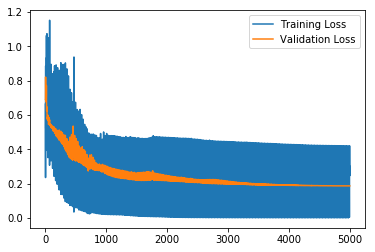

In [58]:
data_sizes = [array.shape[1] for array in transformed_data]
label_size = label_data.shape[1]
max_lr = 1e-4
min_lr = 1e-6
epoch_count = 200
batch_size = 8
out_dim = label_data.shape[1]

train_graph = tf.Graph()
with train_graph.as_default():
    # initialize tf variables
    inputs, labels, lr = cnn1d_inputs(data_sizes, label_size)
    logits, predictions = cnn1d(inputs, label_size)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    model_opt = tf.train.AdamOptimizer(lr).minimize(loss)
    
    batch_i = 0
    train_loss_data = []
    val_loss_data = []
    train_loss = None
    val_loss = None
    
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        print("total trainable parameters:{:,}".format( 
              np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])))
#         print([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

        for epoch_i in range(epoch_count):
            batch_i = 0
            while (batch_i + 1) * batch_size <= len(train_data_indx):
                # extract a batch from the training data and labels
                indx_start = batch_i*batch_size
                indx_end = (batch_i+1)*batch_size
                data_batch = [array[train_data_indx][indx_start:indx_end] for array in transformed_data]
                labels_batch = label_data[train_data_indx][indx_start:indx_end]

                # use adaptive learning rate
                learning_rate = max_lr - (max_lr - min_lr) * ((epoch_i + 1) / epoch_count)
                
                # run model optimizer on the batch
                feed_dict={i: d for i, d in zip(inputs, data_batch)}
                feed_dict.update({labels: labels_batch})
                feed_dict.update({lr: learning_rate})
                _ = sess.run(model_opt, feed_dict=feed_dict)

                if batch_i % 10 == 0:
                    # compute and record the training loss
                    train_loss = loss.eval(feed_dict)
                    train_loss_data.append(train_loss)

                    # compute and record the validation loss
                    val_data = [array[val_data_indx][:] for array in transformed_data]
                    feed_dict = {key: value for key, value in zip(inputs, val_data)}
                    feed_dict.update({labels:label_data[val_data_indx][:]})
                    val_loss = loss.eval(feed_dict=feed_dict)
                    val_loss_data.append(val_loss)

                    # print training losses
                    print("learning_rate {:.4f}...".format(learning_rate),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{} ...".format(batch_i, len(train_data_indx)//batch_size),
                          "Training Loss: {:.4f}...".format(train_loss),
                          "Validation Loss: {:.4f}".format(val_loss),
                          end="  \r",)                    
                batch_i += 1

        print("\nFinished training!",
              "Training Loss: {}...".format(train_loss),
              "Validation Loss: {}".format(val_loss))
        train, = plt.plot(train_loss_data, label="Training Loss")
        val, = plt.plot(val_loss_data, label="Validation Loss")
        plt.legend(handles=[train, val])
        plt.show()
        
        saver = tf.train.Saver()
        saver.save(sess, './cnn1d_4/')

        

In [60]:
with train_graph.as_default():
    inputs, labels, lr = cnn1d_inputs(data_sizes, label_size)
    _, predictions = cnn1d(inputs, label_size, is_train=False)
    with tf.Session(graph=train_graph) as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess, './cnn1d_4/')
        
        val_data = [array[val_data_indx][:] for array in transformed_data]
        feed_dict={i: d for i, d in zip(inputs, val_data)}
        feed_dict.update({labels:labels_batch})
        y_ = sess.run(predictions, feed_dict)
        y = label_data[val_data_indx][:]
        #print(y)
        print("mean absolute error: ", np.mean(np.abs(y_ - y)))

INFO:tensorflow:Restoring parameters from ./cnn1d_4/
mean absolute error:  0.0397301926115577


Since the labels are normalized, we can infer the network's validation accuracy to be 96.03%